In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [2]:
def load_and_preprocess_data():
    customers = pd.read_csv('Customers.csv')
    transactions = pd.read_csv('Transactions.csv')
    
    transaction_aggs = transactions.groupby('CustomerID').agg({
        'TotalValue': ['sum', 'mean', 'count'],
        'Quantity': ['sum', 'mean']
    }).reset_index()
    
    transaction_aggs.columns = [
        'CustomerID', 'total_spend', 'avg_order_value', 'purchase_frequency', 'total_quantity', 'avg_quantity'
    ]
    
    merged_data = customers.merge(transaction_aggs, on='CustomerID')
    merged_data['signup_recency'] = pd.to_datetime('today') - pd.to_datetime(merged_data['SignupDate'])
    merged_data['signup_recency_days'] = merged_data['signup_recency'].dt.days
    
    return merged_data

In [3]:
def prepare_features(merged_data):
    clustering_features = [
        'total_spend', 'avg_order_value', 'purchase_frequency', 'total_quantity', 'signup_recency_days'
    ]
    
    X = merged_data[clustering_features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, merged_data


In [4]:
def perform_clustering_analysis(X_scaled):
    cluster_range = range(2, 11)
    best_result = {'db_index': float('inf'), 'clusters': 0, 'method': ''}
    results = []
    db_indices = []
    silhouette_scores = []

    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans_labels = kmeans.fit_predict(X_scaled)
        
        try:
            db_index = davies_bouldin_score(X_scaled, kmeans_labels)
            silhouette = silhouette_score(X_scaled, kmeans_labels)
            
            results.append({
                'Method': 'KMeans',
                'Clusters': n_clusters,
                'Davies-Bouldin Index': db_index,
                'Silhouette Score': silhouette
            })
            
            db_indices.append(db_index)
            silhouette_scores.append(silhouette)
            
            if db_index < best_result['db_index']:
                best_result = {
                    'db_index': db_index, 
                    'clusters': n_clusters, 
                    'method': 'KMeans',
                    'silhouette': silhouette
                }
        except Exception as e:
            print(f"Error with KMeans, {n_clusters} clusters: {e}")

    plot_clustering_metrics(cluster_range, db_indices, silhouette_scores)
    return pd.DataFrame(results), best_result

In [5]:
def plot_clustering_metrics(cluster_range, db_indices, silhouette_scores):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()
    
    ax1.plot(cluster_range, db_indices, 'ro-', label='DB Index')
    ax2.plot(cluster_range, silhouette_scores, 'bo-', label='Silhouette Score')
    
    ax1.set_xlabel("Number of Clusters")
    ax1.set_ylabel("DB Index", color='r')
    ax2.set_ylabel("Silhouette Score", color='b')
    plt.title("Clustering Metrics")
    plt.legend()
    plt.show()


def visualize_clusters(X_scaled, labels):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    plt.title("Customer Clusters")
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.show()

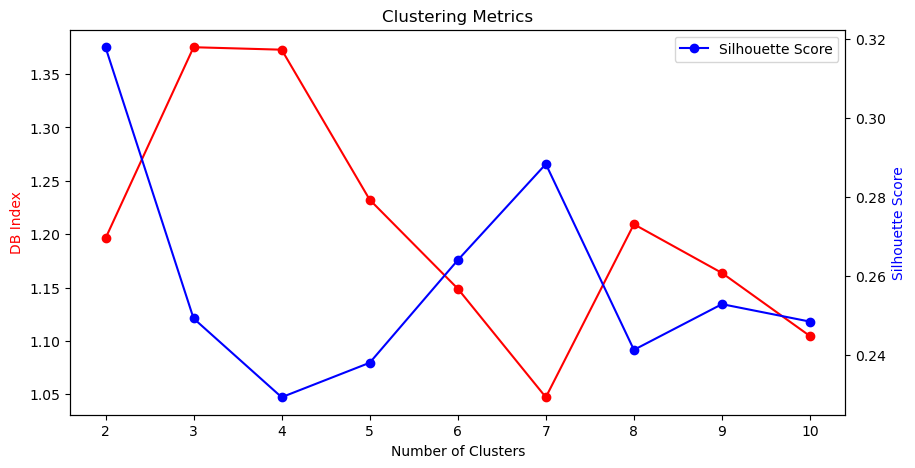

Clustering Performance Metrics:
   Method  Clusters  Davies-Bouldin Index  Silhouette Score
0  KMeans         2              1.196115          0.317877
1  KMeans         3              1.375196          0.249181
2  KMeans         4              1.372883          0.229220
3  KMeans         5              1.232286          0.237951
4  KMeans         6              1.148978          0.263946
5  KMeans         7              1.047247          0.288285
6  KMeans         8              1.209323          0.241218
7  KMeans         9              1.163661          0.252797
8  KMeans        10              1.104493          0.248367

Best Clustering Configuration:
Number of Clusters: 7
Davies-Bouldin Index: 1.0472
Silhouette Score: 0.2883


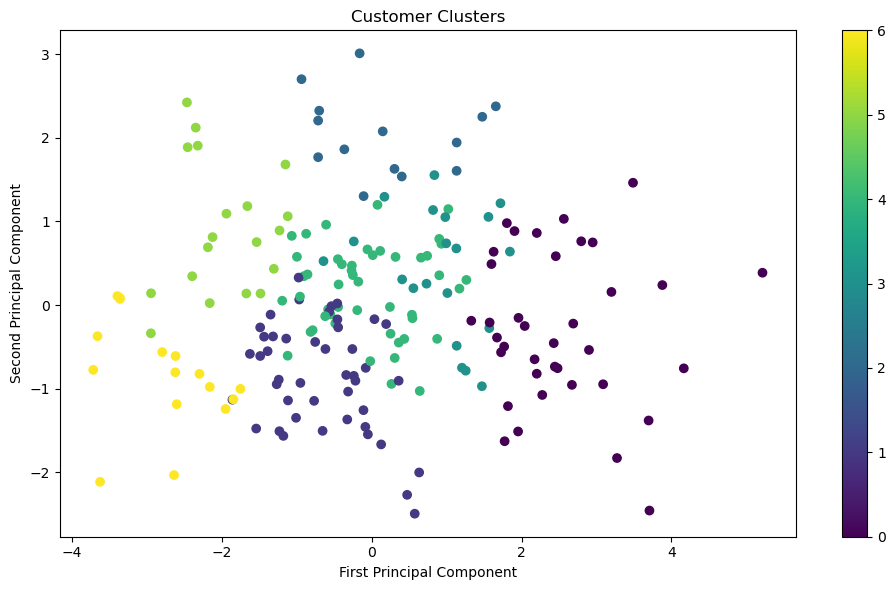


Cluster Profiles:
         total_spend                    purchase_frequency        
                mean      min       max               mean min max
Cluster                                                           
0        6102.532703  4271.61  10673.87           8.162162   6  11
1        2589.028667  1400.83   3730.00           4.511111   3   9
2        4056.183571  2556.22   5780.43           3.857143   2   5
3        4798.654000  3055.22   6072.92           5.050000   3   7
4        3240.508125  1876.10   4807.45           5.479167   4   8
5        1520.051579   580.34   2598.33           2.052632   1   3
6         656.908750    82.36   1191.61           2.375000   1   5


In [6]:
def main():
    merged_data = load_and_preprocess_data()
    X_scaled, original_data = prepare_features(merged_data)
    
    clustering_results, best_config = perform_clustering_analysis(X_scaled)
    print("Clustering Performance Metrics:")
    print(clustering_results)
    
    print("\nBest Clustering Configuration:")
    print(f"Number of Clusters: {best_config['clusters']}")
    print(f"Davies-Bouldin Index: {best_config['db_index']:.4f}")
    print(f"Silhouette Score: {best_config['silhouette']:.4f}")
    
    kmeans = KMeans(n_clusters=best_config['clusters'], random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    
    visualize_clusters(X_scaled, labels)
    
    original_data['Cluster'] = labels
    cluster_profiles = original_data.groupby('Cluster').agg({
        'total_spend': ['mean', 'min', 'max'],
        'purchase_frequency': ['mean', 'min', 'max']
    })
    print("\nCluster Profiles:")
    print(cluster_profiles)


if __name__ == '__main__':
    main()
